In [4]:
# Imported Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

C:\Users\gregory.odiase\AppData\Local\Temp\ipykernel_18712\333008589.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# 1. Project Understanding

**Objective**: Develop a machine learning model to identify fraudulent credit card transactions.

**Project End Goal**: A Web Application to determine if a credit card transaction is fraudulent or not.

**Requirement**: 

    - Credit Card Transaction Data

    - ML Model
    
    - Web Hosting application (streamlit)

# 2. Data Ingestion

In [17]:
# Reading the data set
df = pd.read_csv('card_transdata.csv')
df[df['fraud'] == 1.0].head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
13,2.131956,56.372401,6.358667,1.0,0.0,0.0,1.0,1.0
24,3.803057,67.241081,1.872950,1.0,0.0,0.0,1.0,1.0
29,15.694986,175.989182,0.855623,1.0,0.0,0.0,1.0,1.0
35,26.711462,1.552008,4.603601,1.0,1.0,0.0,1.0,1.0
36,10.664474,1.565769,4.886521,1.0,0.0,0.0,1.0,1.0


In [3]:
# View Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


There are three numerical variables -  distance_from_home, distance_from_last_transaction and ratio_to_median_purchase_price. Also we have five categorical variables - repeat_retailer, used_chip, used_pin_number, online_number and fraud

In [4]:
# View statistical numerations of numerical features
df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182
std,65.390784,25.843093,2.799589
min,0.004874,0.000118,0.004399
25%,3.878008,0.296671,0.475673
50%,9.967760,0.998650,0.997717
75%,25.743985,3.355748,2.096370
max,10632.723672,11851.104565,267.802942


suspected outliers based on the mean and std values

# 3. Data Preparation

In [ ]:
# detect outliers using box plot for distance_from_home feature
sns.boxplot(y=df['distance_from_home'])

Although outliers are detected, based on domain knowledge these values are realistic.

In [ ]:
# detect outliers using box plot for distance_from_home feature
sns.boxplot(y=df['distance_from_last_transaction'])

Although outliers are detected, based on domain knowledge these values are realistic.

In [ ]:
# detect outliers using box plot for distance_from_home feature
sns.boxplot(y=df['ratio_to_median_purchase_price'])

Although outliers are detected, based on domain knowledge these values are realistic.

We can see that although outliers exist for the three categorical features, based on domain knowledge we know that these values are actually achievable. Fraud transactions can lead to these wide variances.

Based on this observation, the best models to utilize going forward would be models that are not sensitive to outliers.

In [ ]:
# check unique values of repeat retailer feature
df['repeat_retailer'].unique()

In [ ]:
# check unique values of used_chip feature
df['used_chip'].unique()

In [ ]:
# check unique values of used_pin_number feature
df['used_pin_number'].unique()

In [ ]:
# check unique values of online_order feature
df['online_order'].unique()

In [ ]:
# check unique values of fraud feature
df['fraud'].unique()

# 4. Exploratory Data Analysis

## 4.0.1. What is the average distance_from_home for fraudulent transactions compared to non-fraudulent transactions?

In [ ]:
# This helps to identify potential patterns in the spatial location of fraud
average_distance_from_home_fraud = df.groupby('fraud')['distance_from_home'].mean()
print(average_distance_from_home_fraud)


Mean distance from home for fraudulent transactions is 4 times that of non-fraudulent transactions

## 4.0.2. Are repeat retailers more susceptible to fraudulent transactions?

In [ ]:
# This helps to understand the relationship between repeat transactions and fraud
df_fraud = df[df['fraud'] == 1.0]
df_non_repeat_count = len(df_fraud[df_fraud['repeat_retailer'] == 0.0])
df_repeat_count = len(df_fraud[df_fraud['repeat_retailer'] == 1.0])

prob_non_repeat = df_non_repeat_count / len(df_fraud)
prob_repeat = df_repeat_count / len(df_fraud)

print(f"The probability of non repeat retailers being fraudulent is = {prob_non_repeat}")
print(f"The probability of repeat retailers being fraudulent is = {prob_repeat}")

Transactions done by Repeat Retailers are more likely to be fraudulent

## 4.0.3. Do transactions with online orders have a higher likelihood of being fraudulent?

In [ ]:
# Investigate the impact of online orders on fraud
df_fraud = df[df['fraud'] == 1.0]
df_non_order_count = len(df_fraud[df_fraud['online_order'] == 0.0])
df_order_count = len(df_fraud[df_fraud['online_order'] == 1.0])

prob_non_order = df_non_order_count / len(df_fraud)
prob_order = df_order_count / len(df_fraud)

print(f"The probability of non online orders being fraudulent is = {prob_non_order}")
print(f"The probability of online orders being fraudulent is = {prob_order}")

Online orders have a higher likelihood of being fraudulent.

## 4.0.4. What is the average distance from last transaction for fraudulent and non-fraudulent transaction?

In [ ]:
# Explore whether recent transaction distances are related to fraud
average_distance_from_last_tran_fraud = df.groupby('fraud')['distance_from_last_transaction'].mean()
print(average_distance_from_last_tran_fraud)


The average distance from last transaction for fraudulent transactions is higher than that of non-fraudulent transactions

## 4.0.5. How does the ratio to median purchase price vary for fraudulent and non-fraudulent transactions?

In [ ]:
# Examine the impact of the ratio on fraud
ratio_to_median_fraud = df.groupby('fraud')['ratio_to_median_purchase_price'].mean()
print(ratio_to_median_fraud)


the ratio_to_median_purchase_price for fraud to non_fraud is 6:1

## 4.0.6. Is fraud more common with transactions using chip or pin number?

In [ ]:
# Evaluate the impact of payment methods on fraud

# fraud dataframe
df_fraud = df[df['fraud'] == 1.0]

# used_chip/non_chip count
df_non_chip_count = len(df_fraud[df_fraud['used_chip'] == 0.0])
df_chip_count = len(df_fraud[df_fraud['used_chip'] == 1.0])

# pin and non_pin count
df_non_pin_count = len(df_fraud[df_fraud['used_pin_number'] == 0.0])
df_pin_count = len(df_fraud[df_fraud['used_pin_number'] == 1.0])

# chip and non_chip probability
prob_non_chip = df_non_chip_count / len(df_fraud)
prob_chip = df_chip_count / len(df_fraud)

# pin and non_pin probabilty
prob_non_pin = df_non_pin_count / len(df_fraud)
prob_pin = df_pin_count / len(df_fraud)

print(f"The probability of non chip transactions being fraudulent is = {prob_non_chip}")
print(f"The probability of chip transactions being fraudulent is = {prob_chip}")
print('\n\n')
print(f"The probability of non pin transactions being fraudulent is = {prob_non_pin}")
print(f"The probability of pin transactions being fraudulent is = {prob_pin}")


fraud is most common where chip and pin is not used.

## 4.0.7. What are the most important features for predicting fraud based on a machine learning model?

In [ ]:
# Train a model and analyze feature importance.


# Assuming X contains the features and y is the target variable
X = df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier. Random forest was chosen because it is not sensitive to outliers.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
print(feature_importance)



**distance_from_home (13.49%):** This feature contributes about 13.49% to the model's predictive performance. It suggests that the distance from home plays a moderate role in predicting whether a transaction is fraudulent.

**distance_from_last_transaction (4.57%):** This feature has a lower importance (4.57%), indicating that it has a relatively smaller impact on predicting fraud compared to other features.

**ratio_to_median_purchase_price (52.72%):** This feature has the highest importance (52.72%), indicating that it is the most influential in predicting fraudulent transactions. A higher ratio to the median purchase price significantly contributes to identifying potential fraud.

**repeat_retailer (0.68%):** The repeat_retailer feature has a very low importance (0.68%), suggesting that it has minimal impact on predicting fraud in the model.

**used_chip (5.21%):** The use of a chip in the transaction contributes around 5.21% to the model's predictive performance.

**used_pin_number (6.39%):** The use of a pin number has a slightly higher importance (6.39%) than using a chip.

**online_order (16.94%):** The online_order feature has a significant impact (16.94%) on predicting fraud, indicating that transactions involving online orders are an important factor in the model's predictions.

## 4.0.8 What is the average 'distance_from_last_transaction' for transactions with online orders compared to those without?

In [ ]:
# Investigate if there is a difference in distance for online and non-online transactions.
distance_online_order = df[ df['fraud']==1.0 ].groupby('online_order')['distance_from_last_transaction'].mean()
print(distance_online_order)


average distance from last transaction on online transactions for fraud cases is lower than that of in-store transactions

## 4.0.9 Are there specific patterns in the ratio of purchase price for repeat retailers?

In [ ]:
# Explore whether repeat retailers exhibit distinct patterns in the ratio to median purchase price.
ratio_repeat_retailer = df[df['fraud']==1.0].groupby('repeat_retailer')['ratio_to_median_purchase_price'].mean()
print(ratio_repeat_retailer)


For fraudulent transactions, the ratio_to_median_purchase for repeat retailers are higher than that of non-repeat retailers 

# 5.0. Feature Engineering

## 5.1.0 Featue Selection

In [5]:
# Assuming X contains the features and y is the target variable
X = df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier. Random forest was chosen because it is not sensitive to outliers.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
print(feature_importance)


distance_from_home                0.134910
distance_from_last_transaction    0.045711
ratio_to_median_purchase_price    0.527171
repeat_retailer                   0.006820
used_chip                         0.052078
used_pin_number                   0.063928
online_order                      0.169382
dtype: float64


# 6.0. Model Development

## 6.0.1 Comparing Models

## 6.0.1.1 Undersampling

In [40]:
# separating class of target variable
no_fraud = df[df['fraud'] == 0]
fraud = df[df['fraud'] == 1]

print(fraud.shape, no_fraud.shape)

(87403, 8) (912597, 8)


In [41]:
# under sample
no_fraud_sample = no_fraud.sample(n=87403)

print(fraud.shape, no_fraud_sample.shape)

(87403, 8) (87403, 8)


In [42]:
# new data frame
df_undersampled = pd.concat([no_fraud_sample, fraud])

df_undersampled['fraud'].value_counts()

fraud
0.0    87403
1.0    87403
Name: count, dtype: int64

In [43]:
# split data set
X = df_undersampled.drop('fraud', axis=1)
y = df_undersampled['fraud']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
log_res = LogisticRegression(max_iter=200)
log_res.fit(X_train, y_train)

log_res_pred = log_res.predict(X_test)

In [47]:
# metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

lr_acc = accuracy_score(y_test, log_res_pred)
lr_prec = precision_score(y_test, log_res_pred)
lr_f1 = f1_score(y_test, log_res_pred)
lr_recall = recall_score(y_test, log_res_pred)

print('Accuracy score = ', lr_acc)
print('Precision score = ', lr_prec)
print('F1 score = ', lr_f1)
print('Recall score = ', lr_recall)

Accuracy score =  0.9421085750243121
Precision score =  0.9345027267105189
F1 score =  0.9426108653737099
Recall score =  0.9508609347291345


## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

In [56]:
# metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print('Accuracy score = ', rf_acc)
print('Precision score = ', rf_prec)
print('F1 score = ', rf_f1)
print('Recall score = ', rf_recall)

Accuracy score =  0.999942795034609
Precision score =  0.999942795034609
F1 score =  0.999942795034609
Recall score =  0.999942795034609


In [69]:
# Visualize results
final_data = pd.DataFrame({'Models': ['LR', 'RF'], "ACC": [lr_acc, rf_acc], 
              "F1":  [lr_f1, rf_f1],
              "PRECISION":  [lr_prec, rf_prec],
              "RECALL":  [lr_recall, rf_recall]
              })

final_data

,Models,ACC,F1,PRECISION,RECALL
0,LR,0.959265,0.721689,0.895777,0.604256
1,RF,0.999943,0.999943,0.999943,0.999943


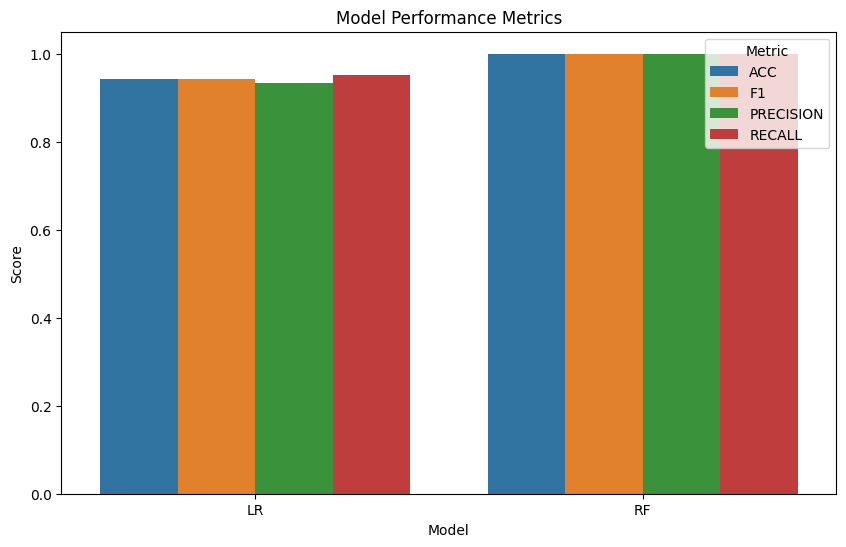

In [58]:
import matplotlib.pyplot as plt

# Melt the DataFrame to long format for easier plotting
final_data_melted = final_data.melt(id_vars='Models', var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=final_data_melted, x='Models', y='Value', hue='Metric')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.show()


## 6.0.1.2 Oversampling

In [59]:
# increasing class of target variable with SMOTE 
X = df.drop('fraud', axis=1)
y = df['fraud']

print(X.shape, y.shape)

(1000000, 7) (1000000,)


In [60]:
# split with stratification
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [61]:
# Apply SMOTE for oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_strat, y_train_strat)

In [62]:
y_train_resampled.value_counts()

fraud
0.0    730078
1.0    730078
Name: count, dtype: int64

### Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression
log_res = LogisticRegression(max_iter=200)
log_res.fit(X_train_strat, y_train_strat)

lg_pred_1 = log_res.predict(X_test_strat)

In [71]:
# metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

lr_acc_1 = accuracy_score(y_test_strat, lg_pred_1)
lr_prec_1 = precision_score(y_test_strat, lg_pred_1)
lr_f1_1 = f1_score(y_test_strat, lg_pred_1)
lr_recall_1 = recall_score(y_test_strat, lg_pred_1)

print('Accuracy score = ', lr_acc_1)
print('Precision score = ', lr_prec_1)
print('F1 score = ', lr_f1_1)
print('Recall score = ', lr_recall_1)

Accuracy score =  0.959265
Precision score =  0.8957767978290366
F1 score =  0.7216889283640214
Recall score =  0.6042560494250901


### Random Forest

In [68]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

rf_pred_1 = rf.predict(X_test_strat)

In [72]:
# metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

rf_acc_1 = accuracy_score(y_test_strat, rf_pred_1)
rf_prec_1 = precision_score(y_test_strat, rf_pred_1)
rf_f1_1 = f1_score(y_test_strat, rf_pred_1)
rf_recall_1 = recall_score(y_test_strat, rf_pred_1)

print('Accuracy score = ', rf_acc_1)
print('Precision score = ', rf_prec_1)
print('F1 score = ', rf_f1_1)
print('Recall score = ', rf_recall_1)

Accuracy score =  0.99997
Precision score =  1.0
F1 score =  0.9998283556470993
Recall score =  0.999656770207654


### Visualize

In [74]:
# Visualize results
final_data_1 = pd.DataFrame({'Models': ['LR', 'RF'], "ACC": [lr_acc_1, rf_acc_1], 
              "F1":  [lr_f1_1, rf_f1_1],
              "PRECISION":  [lr_prec_1, rf_prec_1],
              "RECALL":  [lr_recall_1, rf_recall_1]
              })

final_data

,Models,ACC,F1,PRECISION,RECALL
0,LR,0.959265,0.721689,0.895777,0.604256
1,RF,0.999970,0.999828,1.000000,0.999657


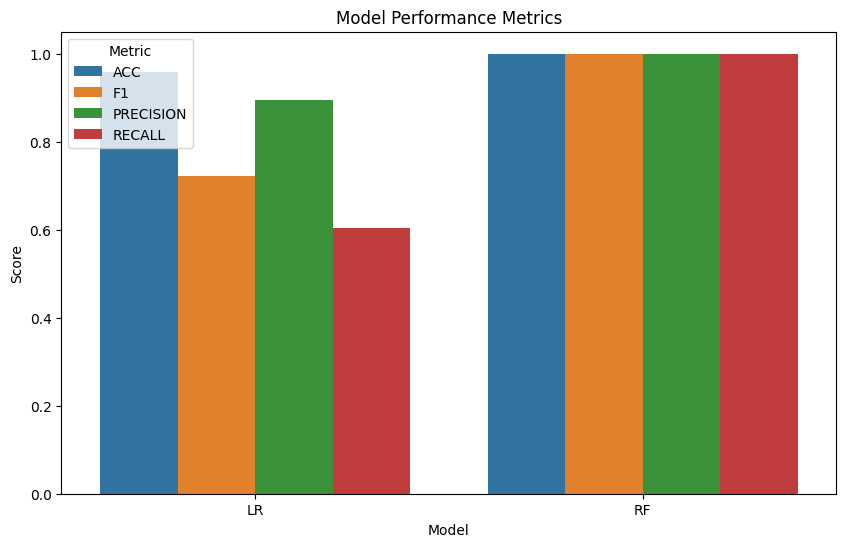

In [75]:
import matplotlib.pyplot as plt

# Melt the DataFrame to long format for easier plotting
final_data_melted_1 = final_data_1.melt(id_vars='Models', var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=final_data_melted_1, x='Models', y='Value', hue='Metric')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.show()

## 6.0.3 threshold tuning

In [6]:
from sklearn.metrics import precision_recall_curve

In [7]:
# dimentsion data
X = df.drop('fraud', axis=1)
y = df['fraud']

In [8]:
# Split data into training and test set. Use Stratify
X_train_thresh, X_test_thresh, y_train_thresh, y_test_thresh = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42 )


In [9]:
# train a randomForestClassifier
rf_model_thresh = RandomForestClassifier(random_state=42)
rf_model_thresh.fit(X_train_thresh, y_train_thresh)

RandomForestClassifier(random_state=42)

In [10]:
from sklearn.metrics import classification_report
y_pred_threshold = rf_model_thresh.predict(X_test_thresh)

thresh_model_initial_result = classification_report(y_test_thresh, y_pred_threshold, output_dict=True)

print("Performance without Threshold Tuning:")
print(thresh_model_initial_result)

Performance without Threshold Tuning:
{'0.0': {'precision': 0.9999671277907136, 'recall': 1.0, 'f1-score': 0.9999835636252068, 'support': 182519.0}, '1.0': {'precision': 1.0, 'recall': 0.999656770207654, 'f1-score': 0.9998283556470993, 'support': 17481.0}, 'accuracy': 0.99997, 'macro avg': {'precision': 0.9999835638953568, 'recall': 0.999828385103827, 'f1-score': 0.999905959636153, 'support': 200000.0}, 'weighted avg': {'precision': 0.9999700009861663, 'recall': 0.99997, 'f1-score': 0.9999699976718802, 'support': 200000.0}}


In [11]:
# predict probabilities for the positive class
y_prob_thresh = rf_model_thresh.predict_proba(X_test_thresh)[:,1]

In [69]:
[x for x in y_pred_threshold if x not in y_prob_thresh]

[]

In [70]:
# compute precision recall threshold
precision, recall, thresholds = precision_recall_curve(y_test_thresh, y_prob_thresh)

In [71]:
# Find the threshold that maximizes the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

In [102]:
best_threshold

0.4

In [72]:
# Apply the threshold to predict binary labels
y_pred_threshold = (y_prob_thresh >= best_threshold).astype(int)

In [103]:
y_pred_threshold

array([0, 1, 0, ..., 0, 0, 0])

In [73]:
# Evaluate the model with the best threshold
from sklearn.metrics import classification_report
thresh_model_final_result = classification_report(y_test_thresh, y_pred_threshold, output_dict=True)

print("Performance with Threshold Tuning:")
print(thresh_model_final_result)

Performance with Threshold Tuning:
{'0.0': {'precision': 0.9999890423567699, 'recall': 1.0, 'f1-score': 0.9999945211483673, 'support': 182519.0}, '1.0': {'precision': 1.0, 'recall': 0.999885590069218, 'f1-score': 0.9999427917620137, 'support': 17481.0}, 'accuracy': 0.99999, 'macro avg': {'precision': 0.9999945211783849, 'recall': 0.9999427950346089, 'f1-score': 0.9999686564551905, 'support': 200000.0}, 'weighted avg': {'precision': 0.9999900001095764, 'recall': 0.99999, 'f1-score': 0.999989999741353, 'support': 200000.0}}


### Visualize results from pre and post threshold tuning

In [76]:
# Extract relevant metrics from each report
metrics = ['precision', 'recall', 'f1-score']
model1_scores = [thresh_model_initial_result['1.0'][metric] for metric in metrics]
model2_scores = [thresh_model_final_result['1.0'][metric] for metric in metrics]

In [86]:
# Create a DataFrame to hold the metrics
df_1 = pd.DataFrame({'Metric': metrics*2,
                   'Model': ['thresh_model_initial_result']*len(metrics) + ['thresh_model_final_result']*len(metrics),
                   'Score': model1_scores + model2_scores})


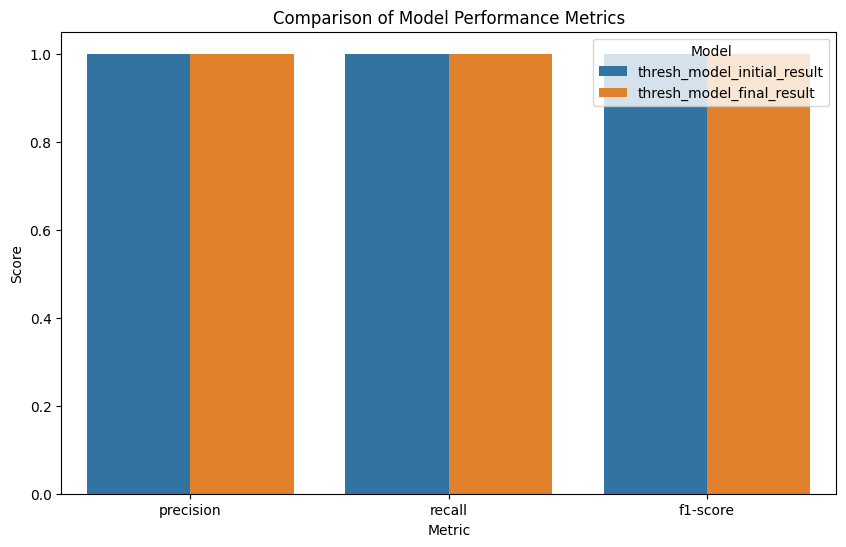

In [87]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_1, x='Metric', y='Score', hue='Model')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.show()

In [97]:
df_1

,Metric,Model,Score
0,precision,thresh_model_initial_result,1.000000
1,recall,thresh_model_initial_result,0.999657
2,f1-score,thresh_model_initial_result,0.999828
3,precision,thresh_model_final_result,1.000000
4,recall,thresh_model_final_result,0.999886
5,f1-score,thresh_model_final_result,0.999943


In [99]:
# Create a pivot table for heatmap
heatmap_df = df_1.pivot_table(index='Metric', columns='Model', values='Score')

In [100]:
# Calculate absolute differences
heatmap_df['Difference'] = abs(heatmap_df['thresh_model_initial_result'] - heatmap_df['thresh_model_final_result'])

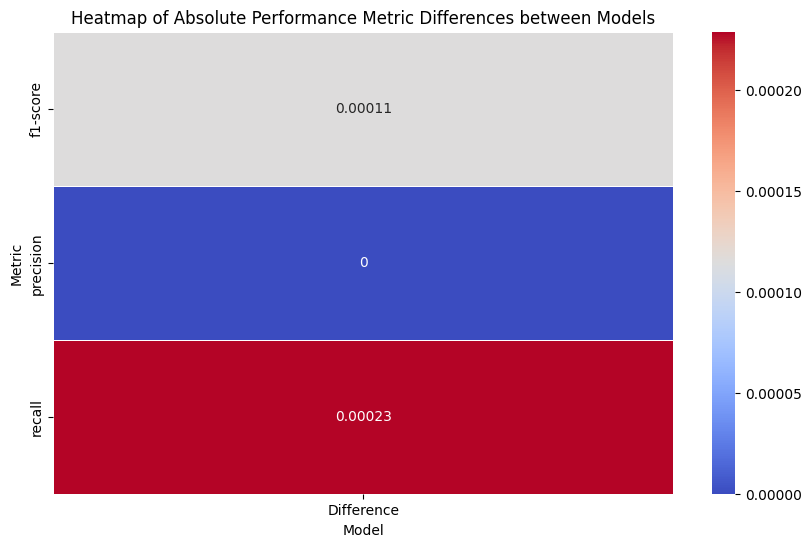

In [101]:
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df[['Difference']], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Absolute Performance Metric Differences between Models')
plt.ylabel('Metric')
plt.xlabel('Model')
plt.show()

## 6.0.4: Using Class Weights 

### Using class weights allows the model to assign higher importance to minority class samples during training, which helps to address the issue of class imbalance and improve the model's ability to predict the minority class.

In [119]:
# get dataset
X = df.drop('fraud',  axis=1)
y = df['fraud']

In [120]:
# splitting data into training and testing set
from sklearn.model_selection import train_test_split

X_train_cw, x_test_cw, y_train_cw, y_test_cw = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [121]:
# Calculate class weights
class_weights = dict(zip([0, 1], ((len(y_train_cw) - y_train_cw.sum()) / len(y_train_cw), y_train_cw.sum() / len(y_train_cw))))
# class_weights = dict(zip([0, 1], ((len(y_train) - y_train.sum()) / len(y_train), y_train.sum() / len(y_train))))

class_weights


{0: 0.9125975, 1: 0.0874025}

In [125]:
# Initialize and train RandomForestClassifier with class weights
rf = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf.fit(X_train_cw, y_train_cw)

RandomForestClassifier(class_weight={0: 0.9125975, 1: 0.0874025},
                       random_state=42)

In [129]:
# Evaluate the model
y_pred = rf.predict(x_test_cw)
class_weight_model= classification_report(y_test_cw, y_pred, output_dict=True)

print("Performance on Test Set:")
class_weight_model

Performance on Test Set:


{'0.0': {'precision': 0.9999726063421797,
  'recall': 1.0,
  'f1-score': 0.9999863029834841,
  'support': 182519.0},
 '1.0': {'precision': 1.0,
  'recall': 0.999713975173045,
  'f1-score': 0.9998569671310468,
  'support': 17481.0},
 'accuracy': 0.999975,
 'macro avg': {'precision': 0.9999863031710898,
  'recall': 0.9998569875865225,
  'f1-score': 0.9999216350572655,
  'support': 200000.0},
 'weighted avg': {'precision': 0.9999750006848415,
  'recall': 0.999975,
  'f1-score': 0.9999749983833018,
  'support': 200000.0}}

In [130]:
# Extract relevant metrics from each report
metrics = ['precision', 'recall', 'f1-score']
# model1_scores = [thresh_model_initial_result['1.0'][metric] for metric in metrics]
# model2_scores = [thresh_model_final_result['1.0'][metric] for metric in metrics]
model3_scores = [class_weight_model['1.0'][metric] for metric in metrics]

In [131]:
model3_scores

[1.0, 0.999713975173045, 0.9998569671310468]

In [132]:
df_1

,Metric,Model,Score
0,precision,thresh_model_initial_result,1.000000
1,recall,thresh_model_initial_result,0.999657
2,f1-score,thresh_model_initial_result,0.999828
3,precision,thresh_model_final_result,1.000000
4,recall,thresh_model_final_result,0.999886
5,f1-score,thresh_model_final_result,0.999943


In [133]:
# Create a DataFrame to hold the metrics
df_2 = pd.DataFrame({'Metric': metrics*3,
                   'Model': ['thresh_model_initial_result']*len(metrics) + ['thresh_model_final_result']*len(metrics) + ['class_weight_model']*len(metrics),
                   'Score': model1_scores + model2_scores + model3_scores})


In [139]:
df_2

,Metric,Model,Score
0,precision,thresh_model_initial_result,1.000000
1,recall,thresh_model_initial_result,0.999657
2,f1-score,thresh_model_initial_result,0.999828
3,precision,thresh_model_final_result,1.000000
4,recall,thresh_model_final_result,0.999886
5,f1-score,thresh_model_final_result,0.999943
6,precision,class_weight_model,1.000000
7,recall,class_weight_model,0.999714
8,f1-score,class_weight_model,0.999857


In [138]:
df_2[df_2['Metric'] == 'recall']

,Metric,Model,Score
1,recall,thresh_model_initial_result,0.999657
4,recall,thresh_model_final_result,0.999886
7,recall,class_weight_model,0.999714


In [141]:
df_2[df_2['Metric'] == 'f1-score']

,Metric,Model,Score
2,f1-score,thresh_model_initial_result,0.999828
5,f1-score,thresh_model_final_result,0.999943
8,f1-score,class_weight_model,0.999857


## Model Export

In [13]:
import pickle

# Assuming 'model' is your trained machine learning model
# Train your model or load it from a file
model = rf_model_thresh

# Specify the filename to save the model
filename = 'pred_fraud_model.pkl'

# Open a file in write-binary mode
with open(filename, 'wb') as file:
    # Serialize the model and write it to the file
    pickle.dump(model, file)


In [14]:
# loading model

# Specify the filename where the model is saved
filename = 'pred_fraud_model.pkl'

# Open the file in read-binary mode
with open(filename, 'rb') as file:
    # Load the model from the file
    loaded_model = pickle.load(file)

# Now, 'loaded_model' contains your model and you can use it for predictions


In [16]:
y_pred_threshold_1 = loaded_model.predict(X_test_thresh)
len(y_pred_threshold_1)

200000